In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

___

### Load dataset

In [5]:
df = pd.read_csv('audi.csv')
ohe_df = df.copy(deep=True)
cat_cols = ['model', 'transmission', 'fuelType']
num_cols = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
label = 'price'

In [6]:
df.shape

(10668, 9)

In [7]:
df.head(10)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0
5,A1,2016,13900,Automatic,32260,Petrol,30,58.9,1.4
6,A6,2016,13250,Automatic,76788,Diesel,30,61.4,2.0
7,A4,2016,11750,Manual,75185,Diesel,20,70.6,2.0
8,A3,2015,10200,Manual,46112,Petrol,20,60.1,1.4
9,A1,2016,12000,Manual,22451,Petrol,30,55.4,1.4


In [5]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000
mean,2017.100675,22896.685039,24827.244001,126.011436,50.770022,1.930709
std,2.167494,11714.841888,23505.257205,67.170294,12.949782,0.602957
min,1997.000000,1490.000000,1.000000,0.000000,18.900000,0.000000
25%,2016.000000,15130.750000,5968.750000,125.000000,40.900000,1.500000
50%,2017.000000,20200.000000,19000.000000,145.000000,49.600000,2.000000
75%,2019.000000,27990.000000,36464.500000,145.000000,58.900000,2.000000
max,2020.000000,145000.000000,323000.000000,580.000000,188.300000,6.300000


In [6]:
df.nunique().to_frame().T

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,26,21,3260,3,7725,3,37,104,19


In [7]:
pd.Series({col: df[col].unique() for col in df[cat_cols]})

model           [ A1,  A6,  A4,  A3,  Q3,  Q5,  A5,  S4,  Q2, ...
transmission                       [Manual, Automatic, Semi-Auto]
fuelType                                 [Petrol, Diesel, Hybrid]
dtype: object

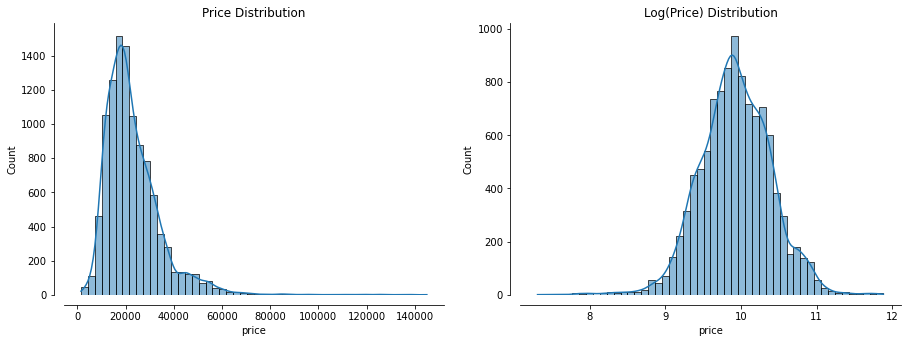

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df[label], kde=True, ax=ax[0], bins=50)
ax[0].set_title(f'{label.title()} Distribution')
sns.histplot(np.log(df[label]), kde=True, ax=ax[1], bins=50)
ax[1].set_title(f'Log({label.title()}) Distribution')
sns.despine(offset=10)
plt.show()

___

#### Label Encoder

In [9]:
lbl_enc = {}
for col in cat_cols:
    lbl_enc[col] = LabelEncoder()
    lbl_enc[col].fit(df[col])

for col in cat_cols:
    df[col] = lbl_enc[col].transform(df[col])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=label), df[label], test_size=0.3, random_state=37)

#### Standard Scaler

In [11]:
scaler = StandardScaler()
scaler.fit(X_train[num_cols])

num_X_train = pd.DataFrame(scaler.transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
num_X_test = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)

In [12]:
X_train = pd.concat([num_X_train, X_train[cat_cols]], axis=1)
X_test = pd.concat([num_X_test, X_test[cat_cols]], axis=1)

# Using log actually gave worse results
# y_train = np.log(y_train)
# y_test = np.log(y_test)

### Model with embeddings

In [13]:
cat_dims = [int(df[col].nunique()) for col in cat_cols]
emb_size = [(x, min(50, (x + 1) // 2)) for x in cat_dims]

In [14]:
def emb_model(cat_cols, num_cols, emb_size):
    inputs = []
    outputs = []
    for cat, sz in zip(cat_cols, emb_size):
        _in = tf.keras.layers.Input(shape=(1,), name=f'in_{cat}')
        inputs.append(_in)
        _emb = tf.keras.layers.Embedding(sz[0], sz[1], 
                                          name=f'emb_{cat}')(_in)

        _emb_rshape = tf.keras.layers.Reshape(target_shape=(sz[1],),
                                              name=f'emb_rsh_{cat}')(_emb)
        outputs.append(_emb_rshape)


    num_in = tf.keras.layers.Input(shape=(len(num_cols),), name='in_num')
    inputs.append(num_in)
    outputs.append(num_in)
    x = tf.keras.layers.Concatenate()(outputs)
    
    x = tf.keras.layers.Dense(128, name='fc1', activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, name='fc2', activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1, name='pred')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x, name='mlp_w_embeddings')
    return model

In [15]:
mlp_emb = emb_model(cat_cols, num_cols, emb_size)

In [16]:
mlp_emb.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [17]:
def create_dataset(data, cat_cols, num_cols):
    input_vals = {}
    for cat in cat_cols:
        input_vals[f"in_{cat}"] = data[cat]
    input_vals["in_num"] = data[num_cols]
    return input_vals

In [18]:
train_ds = create_dataset(X_train, cat_cols, num_cols)
test_ds = create_dataset(X_test, cat_cols, num_cols)

In [19]:
results = mlp_emb.fit(train_ds, y_train, epochs=50, validation_data=(test_ds, y_test), verbose=0)

In [20]:
def results_to_df(results):
    hist = pd.DataFrame(results.history)
    hist['epoch'] = hist.index + 1
    return hist

In [21]:
hist = results_to_df(results)

In [22]:
def plot_learning_curves(hist, figsize=(20, 5), metrics=('mae', 'val_mae')):
    
    metric, val_metric=metrics
    fig, ax = plt.subplots(1, 2, figsize=figsize,
                           gridspec_kw=dict(width_ratios=[4, 5]))

    sns.lineplot(data=hist, x='epoch', y=metric, ax=ax[0], label=metric)
    sns.lineplot(data=hist, x='epoch', y=val_metric, ax=ax[0], label=val_metric)
    for ypos in ax[0].get_yticks():
        ax[0].axhline(ypos, color='black', alpha=0.1)
    ax[0].set_title('Training Epochs')

    zoom = hist.iloc[(hist.shape[0] // 3):hist.shape[0], :]
    sns.lineplot(data=zoom, x='epoch', y=metric, ax=ax[1], label=metric)
    sns.lineplot(data=zoom, x='epoch', y=val_metric, ax=ax[1], label=val_metric)
    for ypos in ax[1].get_yticks():
        ax[1].axhline(ypos, color='black', alpha=0.1)
    ax[1].set_title('Training Epochs - Zoomed')
    ax[1].get_legend().remove()

    sns.despine(offset=10)
    plt.show()

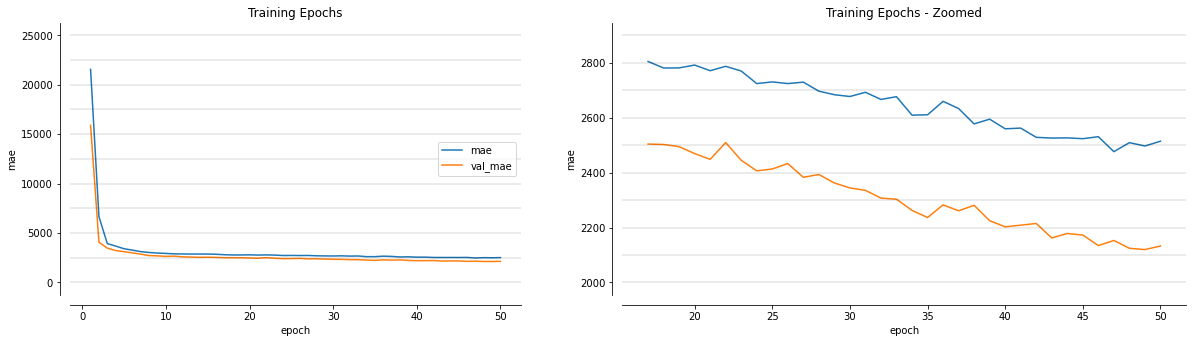

In [23]:
plot_learning_curves(hist, metrics=('mae', 'val_mae'))

- Se observa que el modelo se encuentra entrenado correctamente con un overfit muy pequeño.
- Se realiza un zoom en la segunda imágen para poder obtener un mayor detalle sobre las métricas.

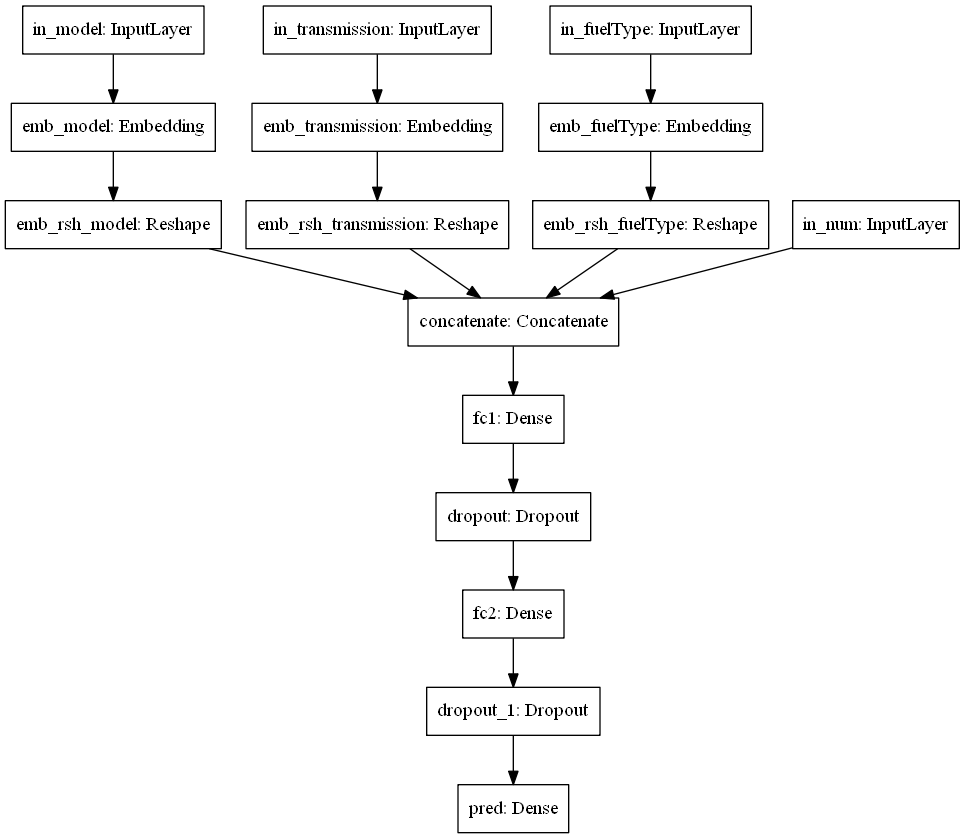

In [24]:
tf.keras.utils.plot_model(mlp_emb, expand_nested=True, to_file='emb_regressor.png')

In [25]:
mlp_emb.summary()

Model: "mlp_w_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_model (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
in_transmission (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
in_fuelType (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
emb_model (Embedding)           (None, 1, 13)        338         in_model[0][0]                   
___________________________________________________________________________________

### Embeddings

In [26]:
emb = mlp_emb.layers[3].get_weights()[0]
emb = pd.DataFrame(emb)
emb.index = lbl_enc['model'].inverse_transform(emb.index)

In [27]:
emb.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12
A1,0.051934,-0.141143,-0.124047,0.080205,-0.141311,0.087796,-0.059565,0.041065,0.126417,0.095381,-0.040843,-0.001488,0.127905
A2,0.148732,-0.188177,0.173475,0.131372,-0.172644,0.124274,-0.180639,0.179293,0.190790,0.183788,-0.115009,0.169395,0.117321
A3,0.158530,-0.129018,0.074663,0.127597,-0.110021,0.074138,-0.141005,0.067386,0.106955,0.152916,-0.116529,0.025921,0.137154
A4,0.093891,-0.172055,0.045253,0.163566,-0.199678,0.170562,-0.132348,0.086259,0.152168,0.103632,-0.127829,0.042758,0.129497
A5,0.181622,-0.211537,0.113676,0.178959,-0.160084,0.152300,-0.192624,0.169556,0.168534,0.152572,-0.109056,0.111200,0.161528
A6,0.184918,-0.187900,0.176300,0.115677,-0.179834,0.197420,-0.186001,0.222054,0.167675,0.150154,-0.249377,0.206839,0.179094
A7,0.228600,-0.237901,0.184940,0.191228,-0.155095,0.202624,-0.163199,0.213448,0.186558,0.113926,-0.170673,0.180437,0.130687
A8,0.208591,-0.239284,0.220276,0.240094,-0.250581,0.228052,-0.217441,0.272953,0.263210,0.228476,-0.194755,0.168446,0.208224
Q2,0.172953,-0.186696,0.024572,0.184084,-0.142126,0.170833,-0.143290,-0.002494,0.098580,0.166658,-0.085331,0.112282,0.166239
Q3,0.174181,-0.207554,0.165406,0.171948,-0.185803,0.145270,-0.161233,0.140091,0.149285,0.172276,-0.201841,0.179547,0.190101


Se realiza PCA para poder visualizar las relaciones entre categorías dentro de la variable y se ajusta para obtener solo 2 componentes.

In [28]:
pca = PCA()
pca.fit(emb)
print(pca.explained_variance_ratio_.cumsum()[0:5])

[0.97375315 0.982357   0.986536   0.98945415 0.9920359 ]


In [29]:
pca = PCA(n_components=2)
emb2dim = pd.DataFrame(pca.fit_transform(emb), index=emb.index, columns=['PC1', 'PC2'])

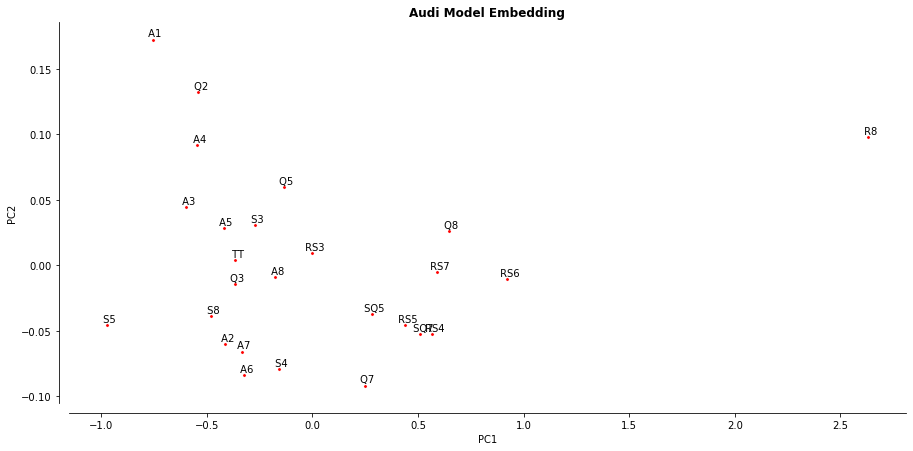

In [30]:
fig, ax = plt.subplots(figsize=(15, 7), facecolor='white')
sns.scatterplot(data=emb2dim, x='PC1', y='PC2', ax=ax, s=10, color='red')
for row in range(len(emb2dim)):
    txt = emb2dim.index[row]
    x = emb2dim.iloc[row, 0]
    y = emb2dim.iloc[row, 1]
    ax.annotate(txt, (x, y), ha='center', fontsize=10, 
                xytext=(1, 3), textcoords='offset points')
sns.despine(offset=10)
ax.set_title('Audi Model Embedding', weight='bold')
plt.show()

In [31]:
pred_result = X_test.copy(deep=True)
pred_result['real'] = y_test
pred_result['pred'] = mlp_emb.predict(test_ds)
pred_result['residuals'] = pred_result['real'] - pred_result['pred']

In [32]:
pred_result

,year,mileage,tax,mpg,engineSize,model,transmission,fuelType,real,pred,residuals
6293,-0.497785,0.672882,-0.011762,0.810474,1.765271,6,0,0,20200,21476.439453,-1276.439453
10006,-0.957521,2.740943,-1.416378,1.262052,0.116972,2,1,0,8500,9293.512695,-793.512695
5753,-0.497785,0.262612,-0.011762,0.435434,0.116972,9,1,0,15750,17019.373047,-1269.373047
10623,0.881422,-0.839805,0.283947,-1.432110,0.116972,9,0,2,37295,32787.222656,4507.777344
6140,1.341158,-0.915328,0.357874,-0.460069,-0.707177,0,2,2,22970,24658.103516,-1688.103516
...,...,...,...,...,...,...,...,...,...,...,...
6352,-0.038050,0.220298,0.283947,-0.926955,1.765271,3,0,2,24895,26376.193359,-1481.193359
28,0.421686,0.008859,0.283947,1.514630,0.116972,3,0,0,17200,19692.812500,-2492.812500
3904,0.881422,-0.879255,0.283947,0.045087,0.116972,3,0,0,28990,25942.921875,3047.078125
9027,-0.497785,0.492729,-1.416378,1.262052,0.116972,3,1,0,16800,14322.519531,2477.480469


In [34]:
mlp_emb.evaluate(test_ds, y_test)

101/101 [==============================] - 0s 2ms/step - loss: 9951164.0000 - mae: 2132.6777


[9951164.0, 2132.677734375]